In [7]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier


In [8]:
# Define dataset path
dataset_path = r"D:\hydralic_systems_project\dataset"  # Use raw string for Windows paths

# Check if the dataset path exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset path does not exist: {dataset_path}")

# List of sensor files
sensor_files = [
    "CE.txt", "CP.txt", "EPS1.txt", "FS1.txt", "FS2.txt", "PS1.txt", "PS2.txt",
    "PS3.txt", "PS4.txt", "PS5.txt", "PS6.txt", "SE.txt", "TS1.txt", "TS2.txt",
    "TS3.txt", "TS4.txt", "VS1.txt"
]

# Read sensor data files and concatenate them
dataframes = []
for file in sensor_files:
    file_path = os.path.join(dataset_path, file)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    df = pd.read_csv(file_path, header=None, delimiter=r'\s+')  # Read the file with space delimiter
    dataframes.append(df)

# Concatenate all dataframes along columns
df = pd.concat(dataframes, axis=1)

# Load target data
profile_path = os.path.join(dataset_path, "profile.txt")
if not os.path.exists(profile_path):
    raise FileNotFoundError(f"Profile file not found: {profile_path}")
profile = pd.read_csv(profile_path, delimiter='\t', header=None)
profile.columns = ['Cooler condition', 'Valve condition', 'Pump Leakage', 'Accumulator Pressure', 'Stable Flag']

# Select target variable
y = profile['Cooler condition']

# Drop the last row of features to match the target size
df = df.iloc[:-1, :]

# Check the first few rows of the data
print(df.head())
print(y.head())


       0       1       2       3       4       5       6       7       8   \
0  47.202  47.273  47.250  47.332  47.213  47.372  47.273  47.438  46.691   
1  29.208  28.822  28.805  28.922  28.591  28.643  28.216  27.812  27.514   
2  23.554  23.521  23.527  23.008  23.042  23.052  22.658  22.952  22.908   
3  21.540  21.419  21.565  20.857  21.052  21.039  20.926  20.912  20.989   
4  20.460  20.298  20.350  19.867  19.997  19.972  19.924  19.813  19.691   

       9   ...     50     51     52     53     54     55     56     57     58  \
0  46.599  ...  0.554  0.552  0.545  0.553  0.553  0.539  0.544  0.545  0.535   
1  27.481  ...  0.555  0.547  0.548  0.544  0.536  0.542  0.540  0.533  0.531   
2  22.359  ...  0.543  0.544  0.543  0.554  0.544  0.544  0.545  0.544  0.530   
3  20.882  ...  0.549  0.538  0.553  0.543  0.553  0.555  0.544  0.543  0.543   
4  19.634  ...  0.546  0.546  0.544  0.552  0.539  0.540  0.549  0.542  0.533   

      59  
0  0.543  
1  0.534  
2  0.534  
3  0.5

In [9]:
# Check for missing values
print("Missing values in features:", df.isnull().sum().sum())
print("Missing values in target:", y.isnull().sum())

# Preprocessing
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print shapes of the scaled data and encoded target labels
print("Shape of df_scaled:", df_scaled.shape)
print("Shape of y_encoded:", y_encoded.shape)


Missing values in features: 0
Missing values in target: 0
Shape of df_scaled: (2204, 43680)
Shape of y_encoded: (2205,)


In [10]:
if not isinstance(y_encoded, pd.Series):
    y_encoded = pd.Series(y_encoded)  # Convert to pandas Series if it's not already



In [11]:
if df_scaled.shape[0] != y_encoded.shape[0]:
    y_encoded = y_encoded.iloc[:df_scaled.shape[0]]  # Align length of y_encoded with df_scaled

# Verify shapes after alignment
print("Aligned shape of df_scaled:", df_scaled.shape)
print("Aligned shape of y_encoded:", y_encoded.shape)


Aligned shape of df_scaled: (2204, 43680)
Aligned shape of y_encoded: (2204,)


In [12]:
print("Type of df_scaled:", type(df_scaled))
print("Type of y_encoded:", type(y_encoded))


Type of df_scaled: <class 'pandas.core.frame.DataFrame'>
Type of y_encoded: <class 'pandas.core.series.Series'>


In [13]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y_encoded, test_size=0.2, random_state=42)

# Ensure that the data is properly split
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# Ensure that X_train and y_train are NumPy arrays
X_train = np.nan_to_num(X_train, nan=0)  # Replace NaNs in X_train with 0
y_train = np.nan_to_num(y_train, nan=0)  # Replace NaNs in y_train with 0

# Ensure X_test is also a NumPy array
X_test = X_test.to_numpy()  # Convert X_test to NumPy array if it's a DataFrame







X_train shape: (1763, 43680), X_test shape: (441, 43680)
y_train shape: (1763,), y_test shape: (441,)


In [14]:
from catboost import CatBoostClassifier

# Initialize the CatBoost model with GPU and optimized parameters
catboost_model = CatBoostClassifier(
    iterations=100,       # Reduced iterations for faster training
    depth=6,              # Reduced depth for quicker training and efficiency
    learning_rate=0.1,    # Adjusted learning rate for faster convergence
    loss_function='MultiClass',
    random_state=42,
    verbose=50,           # Log progress every 50 iterations
    task_type='GPU'       # Enable GPU usage
)

# Fit the model using GPU
catboost_model.fit(X_train, y_train)

# Make predictions
y_pred = catboost_model.predict(X_test)


0:	learn: 0.9143416	total: 728ms	remaining: 1m 12s
50:	learn: 0.0112390	total: 24.8s	remaining: 23.8s
99:	learn: 0.0029112	total: 46.9s	remaining: 0us


In [15]:
from sklearn.model_selection import cross_val_score

# Wrap CatBoost with GPU support
catboost_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    random_state=42,
    task_type='GPU'
)

# Perform cross-validation
scores = cross_val_score(catboost_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())


0:	learn: 0.9218292	total: 742ms	remaining: 1m 13s
1:	learn: 0.7829076	total: 1.18s	remaining: 57.6s
2:	learn: 0.6737441	total: 1.59s	remaining: 51.6s
3:	learn: 0.5880156	total: 2.06s	remaining: 49.5s
4:	learn: 0.5143507	total: 2.48s	remaining: 47.2s
5:	learn: 0.4525734	total: 2.92s	remaining: 45.8s
6:	learn: 0.4018371	total: 3.41s	remaining: 45.3s
7:	learn: 0.3585461	total: 3.9s	remaining: 44.9s
8:	learn: 0.3190505	total: 4.33s	remaining: 43.8s
9:	learn: 0.2847045	total: 4.77s	remaining: 42.9s
10:	learn: 0.2559129	total: 5.25s	remaining: 42.4s
11:	learn: 0.2309404	total: 5.74s	remaining: 42.1s
12:	learn: 0.2087552	total: 6.2s	remaining: 41.5s
13:	learn: 0.1887728	total: 6.66s	remaining: 40.9s
14:	learn: 0.1710122	total: 7.14s	remaining: 40.4s
15:	learn: 0.1551887	total: 7.6s	remaining: 39.9s
16:	learn: 0.1411492	total: 8.09s	remaining: 39.5s
17:	learn: 0.1289746	total: 8.57s	remaining: 39s
18:	learn: 0.1173694	total: 9.03s	remaining: 38.5s
19:	learn: 0.1071654	total: 9.51s	remaining: 

In [16]:
# from sklearn.metrics import roc_curve, auc
# from sklearn.preprocessing import LabelBinarizer
# import matplotlib.pyplot as plt


# # Get the predicted probabilities for each class (multi-class classification)
# y_prob = catboost_model.predict_proba(X_test)

# # Binarize the true labels for multi-class AUC calculation
# lb = LabelBinarizer()
# y_bin = lb.fit_transform(y_test)

# # Initialize dictionaries for storing ROC data
# fpr = {}
# tpr = {}
# roc_auc = {}

# # Calculate ROC curve and AUC for each class
# for i in range(y_bin.shape[1]):
#     fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot ROC curves for all classes
# plt.figure(figsize=(8, 6))
# for i in range(y_bin.shape[1]):
#     plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# # Plot the diagonal line (chance level)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) for CatBoost')
# plt.legend(loc="lower right")
# plt.show()

# # Print AUC for each class
# for i in range(y_bin.shape[1]):
#     print(f'AUC for class {lb.classes_[i]}: {roc_auc[i]:.2f}')


In [17]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, log_loss
import numpy as np

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Precision
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'macro', 'micro', or 'weighted' for multi-class
print("Precision: ", precision)

# Recall (Sensitivity or True Positive Rate)
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall (Sensitivity): ", recall)

# F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-Score: ", f1)

# Specificity (True Negative Rate) for multi-class classification
# For each class, calculate the specificity:
specificities = []
for i in range(cm.shape[0]):
    tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]  # True Negatives
    fp = np.sum(cm[:, i]) - cm[i, i]  # False Positives
    specificity = tn / (tn + fp) if tn + fp != 0 else 0  # Avoid division by zero
    specificities.append(specificity)
    print(f"Specificity for Class {i}: {specificity}")



# # Log Loss (Only for models that output probabilities, not class labels)
# log_loss_value = log_loss(y_test, y_prob)
# print("Log Loss: ", log_loss_value)


Confusion Matrix:
 [[157   0   0]
 [  0 127   0]
 [  0   0 157]]
Precision:  1.0
Recall (Sensitivity):  1.0
F1-Score:  1.0
Specificity for Class 0: 1.0
Specificity for Class 1: 1.0
Specificity for Class 2: 1.0


0:	learn: 0.9329248	total: 741ms	remaining: 1m 13s
1:	learn: 0.8039875	total: 1.11s	remaining: 54.3s
2:	learn: 0.7002924	total: 1.44s	remaining: 46.4s
3:	learn: 0.6149536	total: 1.76s	remaining: 42.4s
4:	learn: 0.5435165	total: 2.09s	remaining: 39.7s
5:	learn: 0.4829312	total: 2.43s	remaining: 38.1s
6:	learn: 0.4310184	total: 2.76s	remaining: 36.7s
7:	learn: 0.3861655	total: 3.1s	remaining: 35.7s
8:	learn: 0.3471471	total: 3.44s	remaining: 34.8s
9:	learn: 0.3130102	total: 3.78s	remaining: 34s
10:	learn: 0.2829993	total: 4.11s	remaining: 33.3s
11:	learn: 0.2565064	total: 4.44s	remaining: 32.6s
12:	learn: 0.2330352	total: 4.78s	remaining: 32s
13:	learn: 0.2121755	total: 5.12s	remaining: 31.5s
14:	learn: 0.1935850	total: 5.45s	remaining: 30.9s
15:	learn: 0.1769756	total: 5.79s	remaining: 30.4s
16:	learn: 0.1621030	total: 6.12s	remaining: 29.9s
17:	learn: 0.1487582	total: 6.49s	remaining: 29.6s
18:	learn: 0.1367615	total: 6.82s	remaining: 29.1s
19:	learn: 0.1259581	total: 7.16s	remaining: 

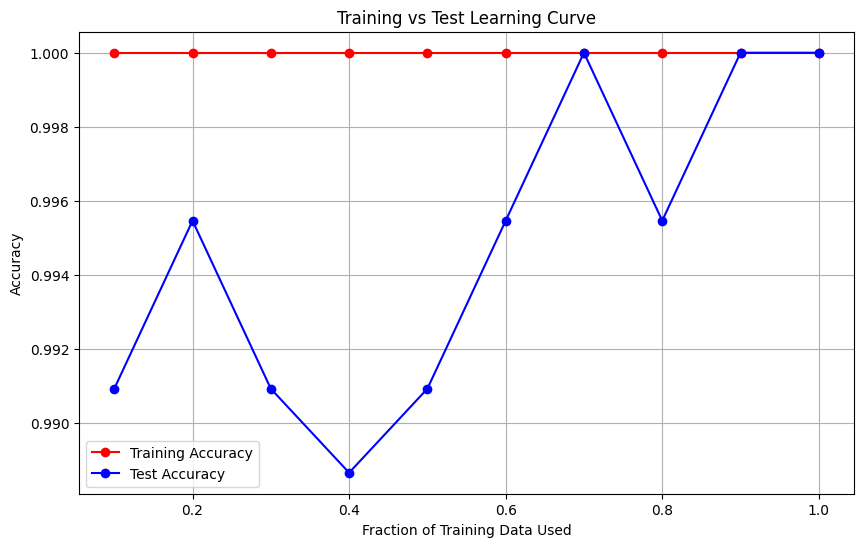

In [18]:

# Function to plot learning curve for train vs test
from sklearn.metrics import accuracy_score
import numpy as np

def plot_train_vs_test_curve(estimator, X_train, y_train, X_test, y_test, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_scores = []
    test_scores = []

    # Loop through different training set sizes
    for train_size in train_sizes:
        # Calculate number of samples
        X_train_partial = X_train[:int(len(X_train) * train_size)]
        y_train_partial = y_train[:int(len(y_train) * train_size)]

        # Fit the model on the partial training set
        estimator.fit(X_train_partial, y_train_partial)

        # Evaluate on the partial training set
        y_train_pred = estimator.predict(X_train_partial)
        train_accuracy = accuracy_score(y_train_partial, y_train_pred)

        # Evaluate on the test set
        y_test_pred = estimator.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Store scores
        train_scores.append(train_accuracy)
        test_scores.append(test_accuracy)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores, 'o-', color="r", label="Training Accuracy")
    plt.plot(train_sizes, test_scores, 'o-', color="b", label="Test Accuracy")
    plt.title("Training vs Test Learning Curve")
    plt.xlabel("Fraction of Training Data Used")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

# Plot the learning curve for XGBoost
plot_train_vs_test_curve(catboost_model, X_train, y_train, X_test, y_test)